In [353]:
import pickle
import glob
import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from typing import Dict, List, Union
from collections import OrderedDict

# Helper functions

In [372]:
def get_batchsize(path: str) -> int:
    """Extract batch size from filename"""
    fname = path.split("/")[-1]
    return int(fname.split("_")[4])


def get_ncpu(path: str) -> int:
    """Extract number of cores from filename"""
    fname = path.split("/")[-1]
    return int(fname.split("_")[2])


def get_actor_fraction(path: str) -> float:
    fname = path.split("/")[-1]
    return float(fname.split("_")[-1][:-4])

def unpack_data(folder: str, seq_fname: str, batch_sizes: List[int], cpu_range: range, actor_cpu_frac: float) -> \
        Dict[str, Union[Dict[str, List], int]]:
    """Returns a dictionary with experiment results"""

    fname_lists = filter_filenames(folder, cpu_range, batch_sizes, actor_cpu_frac)

    # Load data in memory
    ray_data = []
    for lst in fname_lists:
        matching_files = []
        for exp in lst:
            with open(exp, 'rb') as f:
                matching_files.append(pickle.load(f))
        ray_data.append(matching_files)  # type List[Dict[str, Any]]

    seq_data = []
    with open(seq_fname, 'rb') as f:
        seq_data.append([pickle.load(f)])

    ncpu =  cpu_range.stop - cpu_range.start
    return {'data': {'ray': ray_data, 'sequential': seq_data}, 'ncpus': ncpu}


def filter_filenames(folder: str, cpu_range: range, batch_sizes: List[int], actor_cpu_frac: float) -> List[List[str]]:
    """
    Return the filenames from `folder` for specified `batch_sizes`, `cpu_range` and `actor_cpu_frac`. The response:

        - Contains ``len(batch_sizes)`` sub-lists
        - Each sublists contains ``len(list(cpu_range))`` filenames

    Each sublist is sorted by the number of cpus (ascending order).
    """

    fname_lists = [[] for _ in range(len(batch_sizes))]
    batch_size_mapping = {batch_size: i for i, batch_size in enumerate(batch_sizes)}
    for file in glob.glob(f'{folder}/ray_*.pkl'):
        batch_size = get_batchsize(file)
        if batch_size not in batch_size_mapping:
            continue
        ncpu = get_ncpu(file)
        cpu_frac = get_actor_fraction(file)
        if actor_cpu_frac == cpu_frac and ncpu in cpu_range:
            fname_lists[batch_size_mapping[batch_size]].append(file)

    for lst in fname_lists:
        lst.sort(key=get_ncpu)
    
    pprint.pprint(fname_lists)

    return fname_lists



def get_stats(run, field):
    """Calculate average runtime of a given (batch,ncpu_ setting."""
    data = run[field]
    avg = sum(data) / len(data)
    std = np.std(data)
    return avg, std


def extract_timeseries(experiments, field):
    means, stds = [], []
    for batch_size in experiments:
        tmp_mean, tmp_std = [], []
        for ncores in batch_size:
            mu, sigma = get_stats(ncores, field)
            tmp_mean.append(mu)
            tmp_std.append(sigma)
        means.append(tmp_mean)
        stds.append(tmp_std)

    return means, stds


def prepare_data(data_dict, field='t_elapsed', decimals=3):

    ncpus = data_dict['ncpus']
    ray_data =  data_dict['data']['ray']
    sequential_data =  data_dict['data']['sequential']
    ray_means, ray_stds = extract_timeseries(ray_data, field)
    seq_means, seq_stds = extract_timeseries(sequential_data, field)
    mean_arrays = [np.around(np.array(seq_means * ncpus), decimals=decimals)]
    std_arrays = [np.around(np.array(seq_stds * ncpus), decimals=decimals)]
    for mean_arr, std_arr in zip(ray_means, ray_stds):
            mean_arrays.append(np.around(mean_arr, decimals=decimals))
            std_arrays.append(np.around(std_arr, decimals=decimals))
    return mean_arrays, std_arrays


def compare_timing(means, stds, labels, cpu_range, bar_width=0.1, y_min=0, y_max=34.0, y_step=0.5,
                   legend_pos=(1.24, -0.09), yticks_fontsize=20):
    fig, ax = plt.subplots(figsize=(40, 20))

    bar_positions = np.array(np.arange(1, cpu_range.stop - cpu_range.start + 1))
    xticks = [str(x) for x in range(cpu_range.start, cpu_range.stop)]
    bps = []
    with sns.axes_style("white"):
        sns.set_style("ticks")
        sns.set_context("talk")
        for m, s, label in zip(means, stds, labels):
            if len(m.shape) == 2:
                m = m.squeeze()
                s = s.squeeze()
            bar_plot = ax.bar(bar_positions,
                              m,
                              bar_width,
                              yerr=s,
                              label=label,
                              capsize=10
                              )
            bps.append(bar_plot)
            bar_positions = bar_positions + bar_width

        ax.set_xlabel(r'ncpu', fontsize=30)
        ax.set_xticks(bar_positions - 2 * bar_width)
        ax.set_xticklabels(xticks, rotation=45, fontsize=25)

        ax.set_ylabel('Time (s)', fontsize=30)
        ax.set_ylim(top=y_max)
        ax.set_ylim(bottom=y_min)
        y_ticks = np.arange(y_min, y_max, y_step)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks, fontsize=yticks_fontsize)

        ax.grid(True)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), ncol=2, fontsize=20)
        sns.despine()

    return ax, bps


def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)


[['results/ray_ncpu_21_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_22_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_23_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_24_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_25_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_26_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_27_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_28_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_29_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_30_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_31_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_32_bsize_10_actorfr_1.0.pkl',
  'results/ray_ncpu_33_bsize_10_actorfr_1.0.pkl'],
 ['results/ray_ncpu_21_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_22_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_23_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_24_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_25_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_26_bsize_20_actorfr_1.0.pkl',
  'results/ray_ncpu_27_bsize_20_actorfr_1.0.pkl',

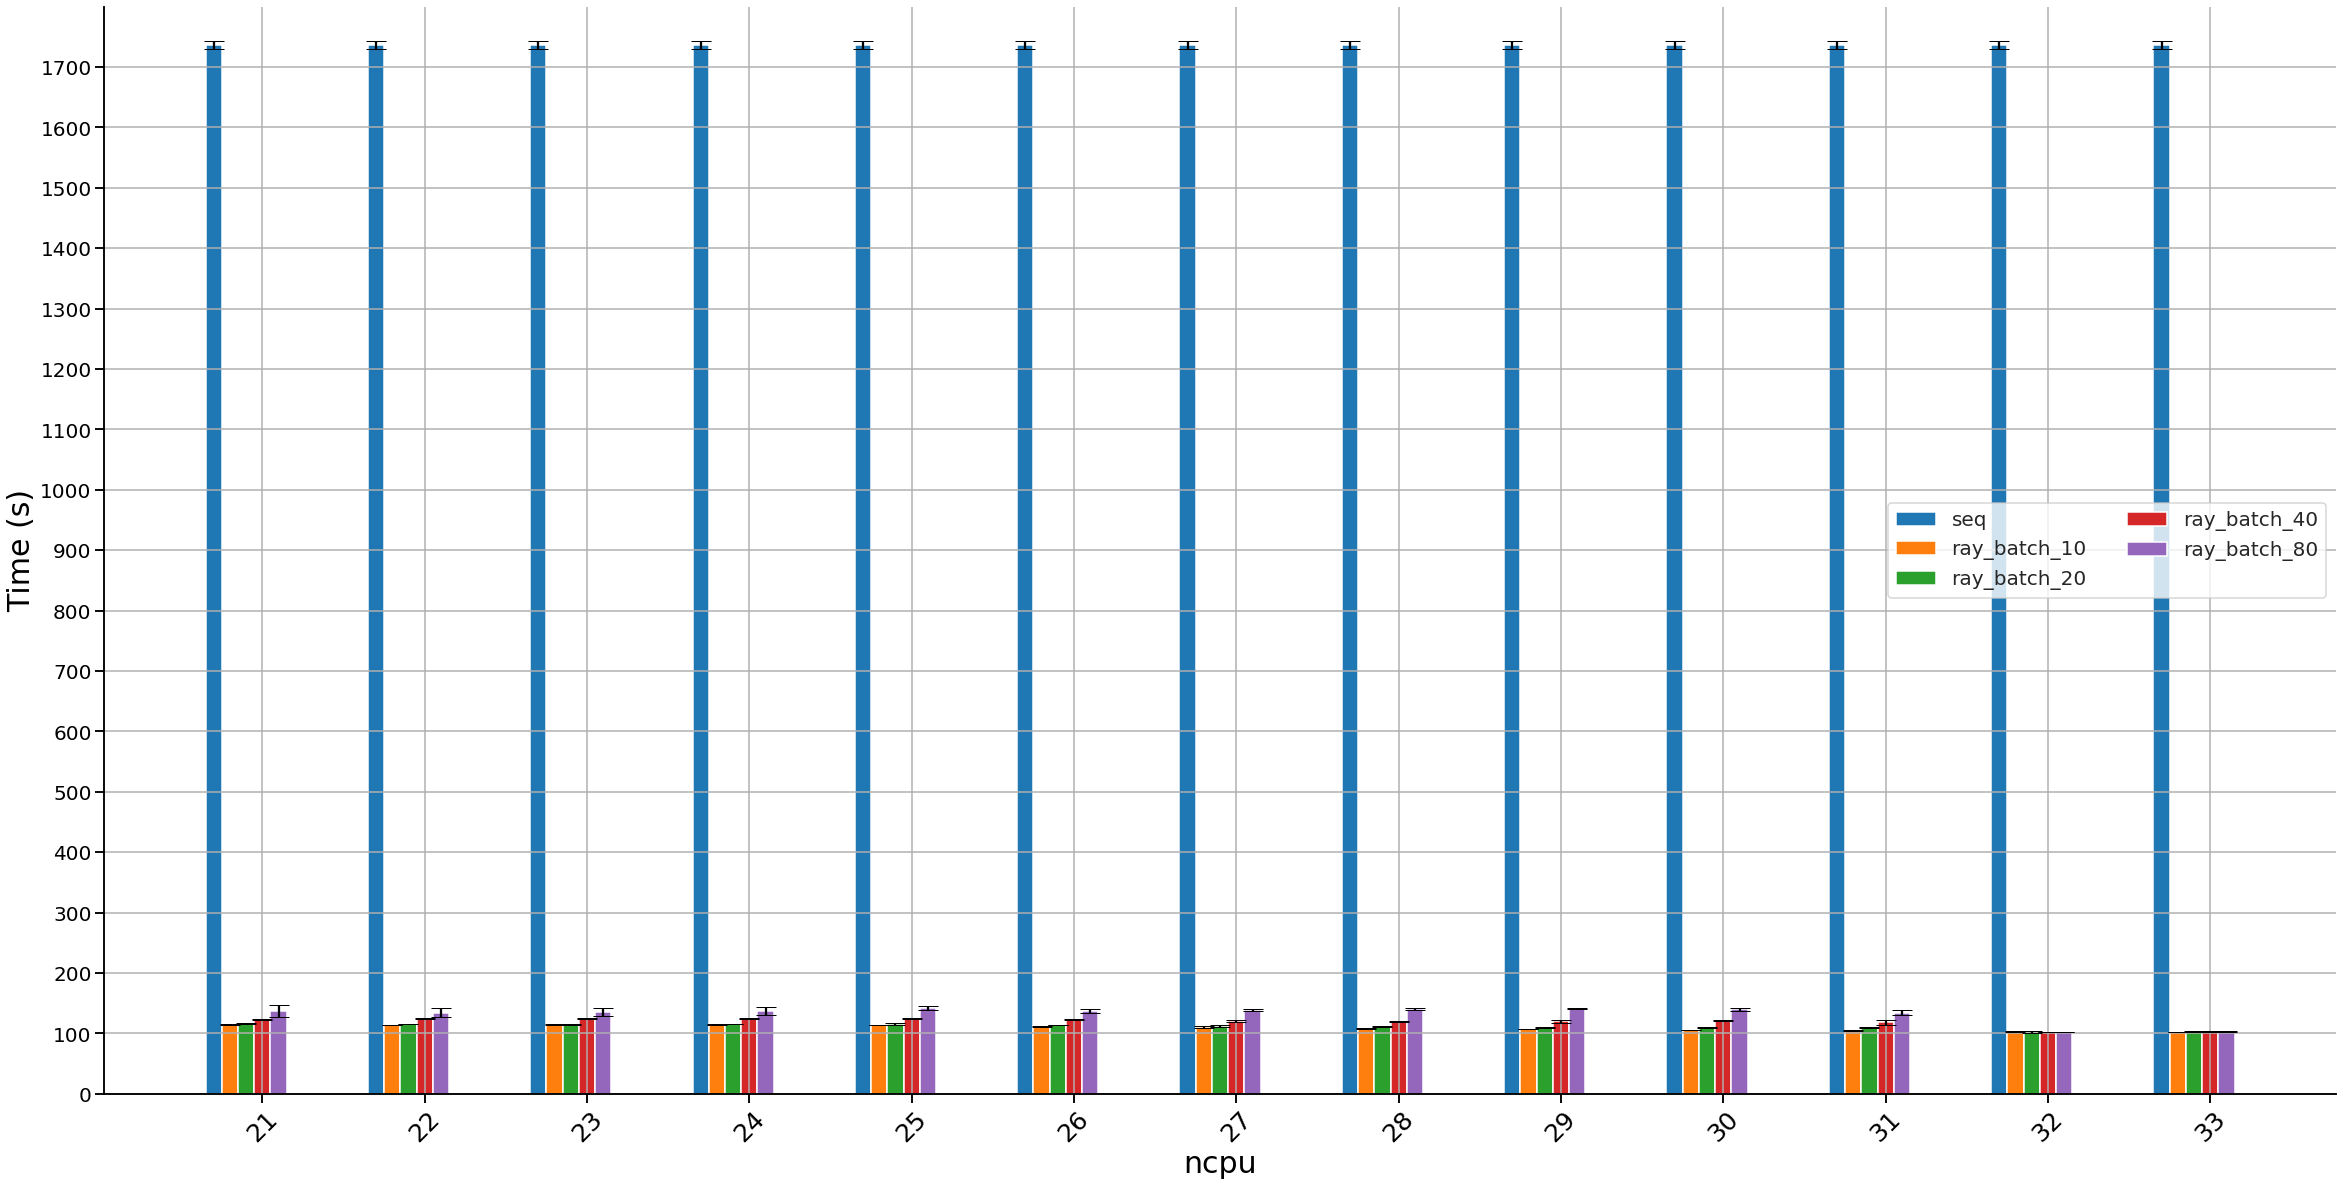

In [389]:
actor_fraction = 1.0
sequential_file = 'results/sequential.pkl'
batch_sizes = [10, 20, 40, 80]
cpu_range = range(21, 34)
folder = 'results'
labels = ['seq'] + ['ray_batch_{}'.format(size) for size in batch_sizes]
data = unpack_data(folder, sequential_file, batch_sizes, cpu_range, actor_fraction)
mean, std = prepare_data(data)
ax, bps = compare_timing(mean, std, labels, cpu_range, y_max=1800, y_step=100)


[['results/ray_ncpu_2_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_3_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_4_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_5_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_6_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_7_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_8_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_9_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_10_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_11_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_12_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_13_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_14_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_15_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_16_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_17_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_18_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_19_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_20_bsize_10_actorfr_0.5.pkl'],
 ['results/ray_ncpu_2_bsize_20_actorfr_0.5.pkl',
  'resul

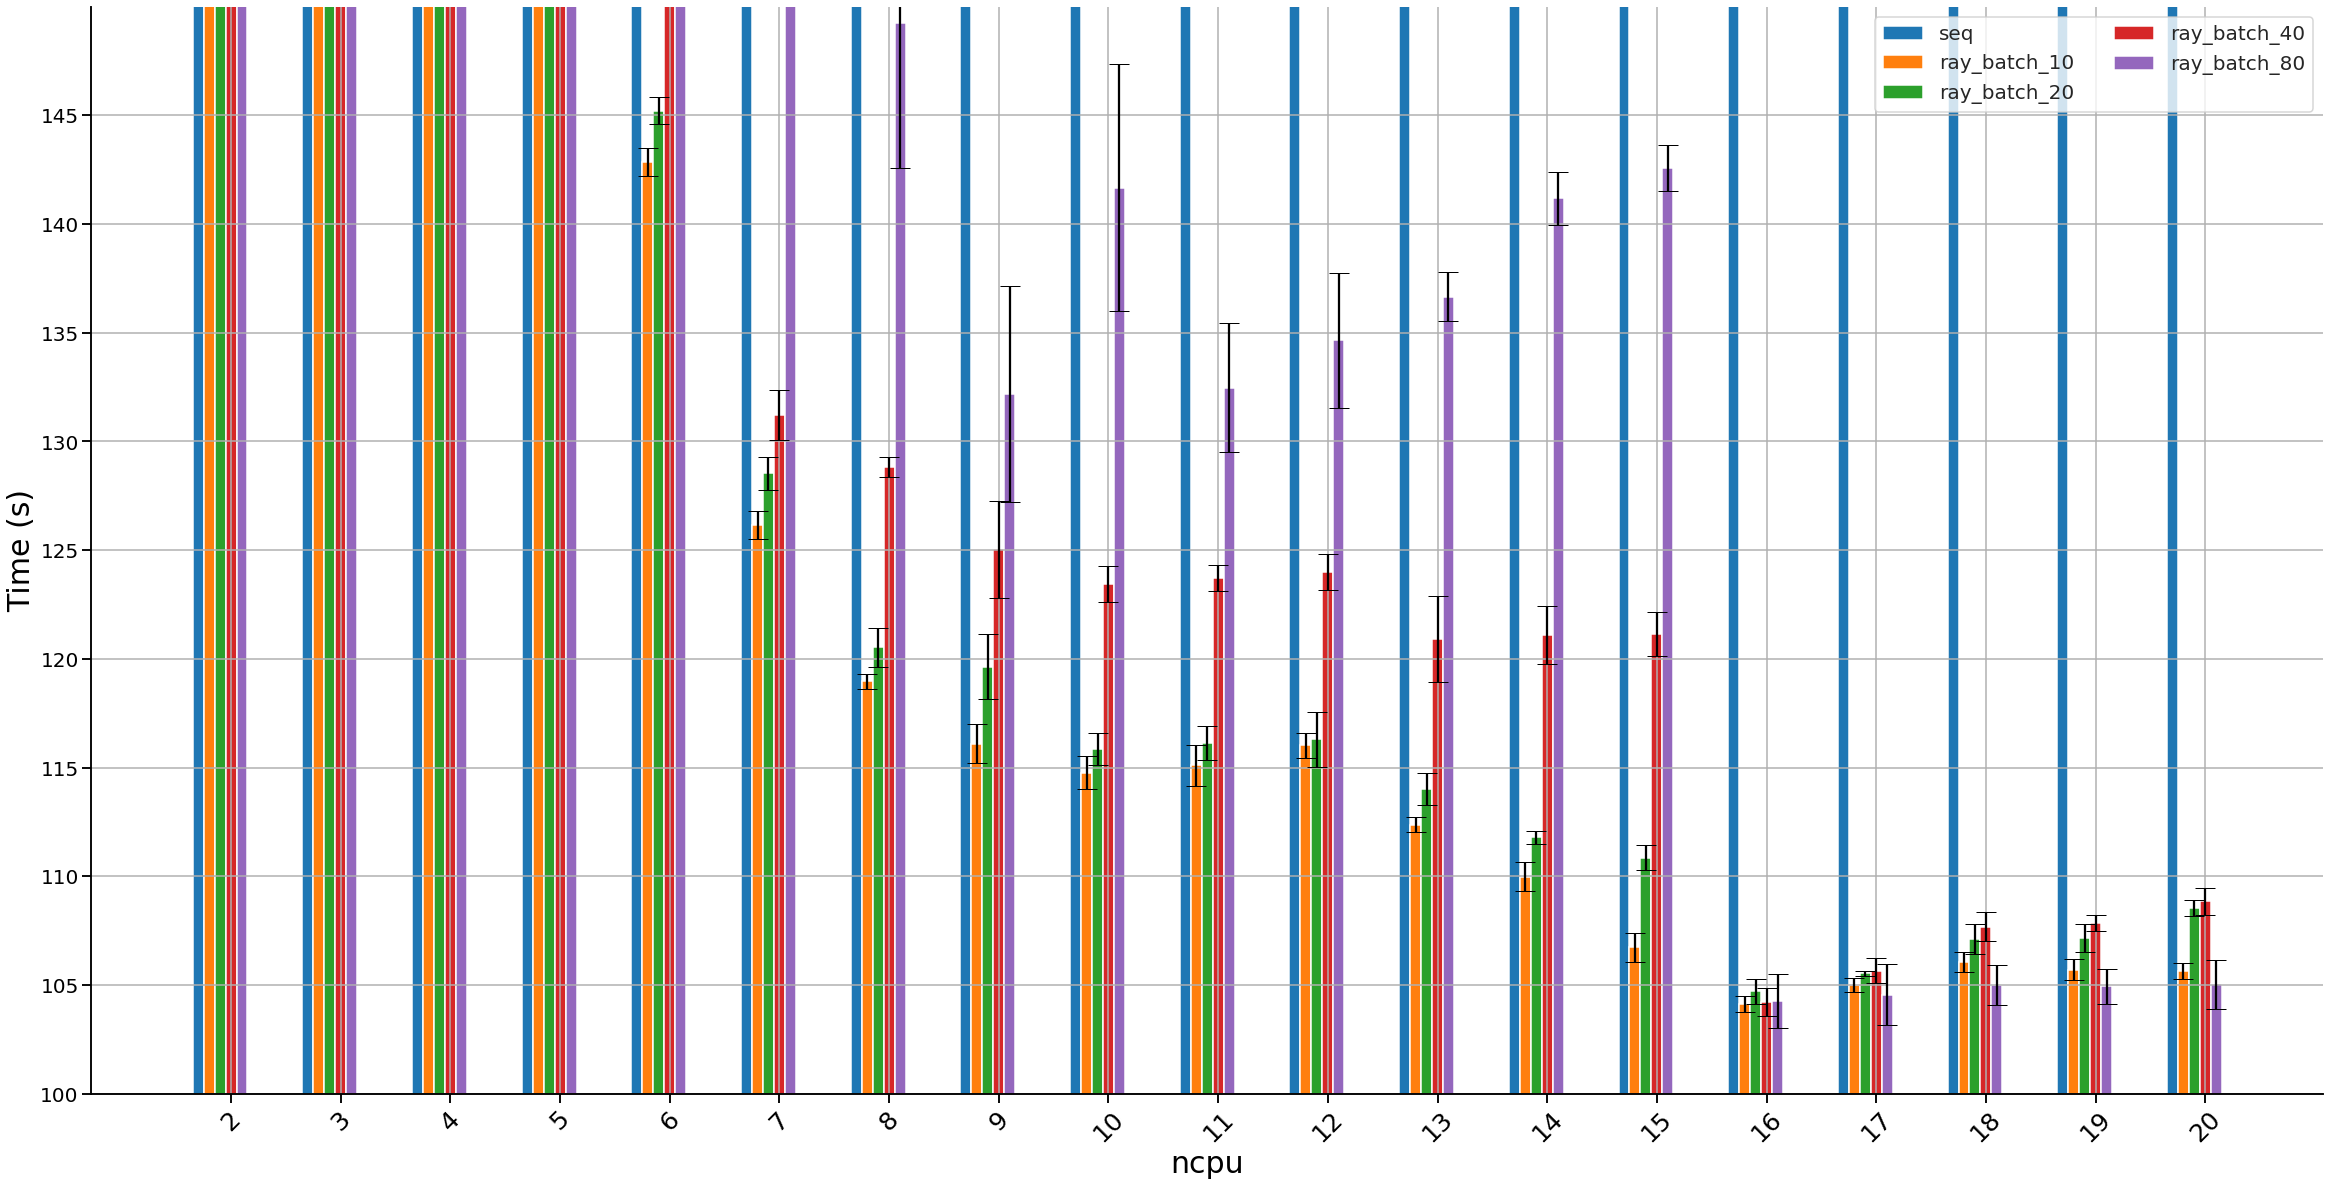

In [386]:
actor_fraction = 0.5
sequential_file = 'results/sequential.pkl'
batch_sizes = [10, 20, 40, 80]
cpu_range = range(2, 21)
folder = 'results'
labels = ['seq'] + ['ray_batch_{}'.format(size) for size in batch_sizes]
data = unpack_data(folder, sequential_file, batch_sizes, cpu_range, actor_fraction)
mean, std = prepare_data(data)
ax, bps = compare_timing(mean, std, labels, cpu_range, y_max=150, y_min=100, y_step=5)

## Sanity checks

In [7]:
with open('results/ray_ncpu_2_bsize_40_actorfr_0.2.pkl', 'rb') as f:
    times = pickle.load(f)['t_elapsed']
print(np.mean(times))

FileNotFoundError: [Errno 2] No such file or directory: 'results/ray_ncpu_2_bsize_40_actorfr_0.2.pkl'

In [23]:
z = [[]*5]

In [24]:
z

[[]]

In [25]:
ray_files

['test_results/ray_ncpu_2_bsize_10_actorfr_1.0.pkl',
 'test_results/ray_ncpu_2_bsize_20_actorfr_1.0.pkl',
 'test_results/ray_ncpu_2_bsize_40_actorfr_1.0.pkl',
 'test_results/ray_ncpu_2_bsize_80_actorfr_1.0.pkl',
 'test_results/ray_ncpu_3_bsize_10_actorfr_1.0.pkl',
 'test_results/ray_ncpu_3_bsize_20_actorfr_1.0.pkl',
 'test_results/ray_ncpu_3_bsize_40_actorfr_1.0.pkl',
 'test_results/ray_ncpu_3_bsize_80_actorfr_1.0.pkl']

In [56]:
a, b = 6, 7
bsize=80
glob.glob(f'results/*_[{a}-{b}]_bsize_{bsize}*')

['results/ray_ncpu_6_bsize_80_actorfr_0.5.pkl',
 'results/ray_ncpu_6_bsize_80_actorfr_1.0.pkl',
 'results/ray_ncpu_7_bsize_80_actorfr_0.5.pkl',
 'results/ray_ncpu_7_bsize_80_actorfr_1.0.pkl']

In [346]:
folder = 'results'
cpu_range = range(17, 29)
actor_cpu_frac = 1.0
batch_sizes = [10, 20]

In [244]:
!ls -l results/

total 1574856
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:23 ray_ncpu_10_bsize_10_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:22 ray_ncpu_10_bsize_10_actorfr_1.0.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:22 ray_ncpu_10_bsize_20_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:26 ray_ncpu_10_bsize_20_actorfr_1.0.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:22 ray_ncpu_10_bsize_40_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:21 ray_ncpu_10_bsize_40_actorfr_1.0.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:22 ray_ncpu_10_bsize_80_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:25 ray_ncpu_10_bsize_80_actorfr_1.0.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:25 ray_ncpu_11_bsize_10_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:25 ray_ncpu_11_bsize_10_actorfr_1.0.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:21 ray_ncpu_11_bsize_20_actorfr_0.5.pkl
-rw-r--r-- 1 alex alex 7790056 Aug  5 11:24 ray_ncpu_11_bsize_20_actorfr_1.0.pkl
-rw-r--r-- 1 a